In [1]:
import pandas as pd
import numpy as np
import pickle
from CPH_h import cph_KFold, plot_survival_curves_for_stage
from lifelines.statistics import proportional_hazard_test
from sksurv.metrics import brier_score, cumulative_dynamic_auc
from sksurv.util import Surv
import matplotlib.pyplot as plt

# Load Data Sources into Pandas Dataframes

In [2]:
# MIMIC-IV base data set
df_base = pd.read_pickle('../MIMIC_IV/df_ckd_base.pkl')
df_master = pd.read_pickle('../MIMIC_IV/df_ckd_master_clean.pkl')

# Initial View of the MIMIC-IV Base Dataset (Only KFRE Risk Factors)
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14012 entries, 0 to 14011
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   subject_id                        14012 non-null  int64  
 1   gender                            14012 non-null  int64  
 2   anchor_age                        14012 non-null  Int64  
 3   disch_age                         14012 non-null  int64  
 4   CKD_stage_first                   14012 non-null  float64
 5   first_stage_icd                   14012 non-null  int64  
 6   stage_delta                       14012 non-null  float64
 7   duration                          14012 non-null  int64  
 8   eGFR_first                        14012 non-null  float64
 9   eGFR_last                         14012 non-null  float64
 10  eGFR_min                          14012 non-null  float64
 11  eGFR_max                          14012 non-null  float64
 12  eGFR

# Join MIMIC-IV Base Dataset with Top 40 Features Identified By FCNN

In [3]:
# Load the list from the pickle file
with open('../FCNN/FCNN40.pkl', 'rb') as f:
    FCNN40 = pickle.load(f)

print(FCNN40)

['Creatinine_last', 'Other and unspecified hyperlipidemia', 'race_WHITE', 'Renal dialysis status', 'Chloride_max', 'Creatinine_first', 'Acute kidney failure, unspecified', 'Urea_Nitrogen_max', 'Creatinine_max', 'Urea_Nitrogen_mean', 'Anemia, unspecified', 'Esophageal reflux', 'Urea_Nitrogen_median', 'MCHC_min', 'Sodium_max', 'Potassium_max', 'admission_type_EW EMER.', 'Creatinine_mean', 'Neutrophils_min', 'admission_location_EMERGENCY ROOM', 'Sodium_min', 'Personal history of tobacco use', 'White_Blood_Cells_min', 'Unspecified essential hypertension', 'Acute on chronic diastolic heart failure', 'Subendocardial infarction, initial episode of care', 'Neutrophils_max', 'Personal history of transient ischemic attack (TIA), and cerebral infarction without residual deficits', 'Peripheral vascular disease, unspecified', 'race_BLACK/AFRICAN AMERICAN', 'Osteoporosis, unspecified', 'admit_provider_id_P38TI6', 'hadm_id_last', 'Creatinine_min', 'MCHC_max', 'Urea_Nitrogen_last', 'admit_provider_id_

In [4]:
# Select these columns from df_source
FCNN40 = ['subject_id'] + FCNN40
df_FCNN40 = df_master[FCNN40]

df_plusFCNN = pd.merge(df_base, df_FCNN40, on='subject_id', how='outer')

df_plusFCNN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14012 entries, 0 to 14011
Data columns (total 84 columns):
 #   Column                                                                                                      Non-Null Count  Dtype  
---  ------                                                                                                      --------------  -----  
 0   subject_id                                                                                                  14012 non-null  int64  
 1   gender                                                                                                      14012 non-null  int64  
 2   anchor_age                                                                                                  14012 non-null  Int64  
 3   disch_age                                                                                                   14012 non-null  int64  
 4   CKD_stage_first                                                 

# Fit Base Cox Proportional Hazards Model

In [5]:
# Drop unecessary columns
df_plusFCNN.drop('first_stage_icd', axis=1, inplace=True)

# Five-fold cross validation to fit model
best_c_index, avg_c_index, cph, train, test = cph_KFold(df_plusFCNN, n_splits=5, penalizer=0.0007)

# Output the average C-index from cross validation
print(f'Average C-Index from cross-validation: {avg_c_index:.4f}')

# Output the best C-index and the corresponding train/test split indices
print(f'Best C-Index from cross-validation: {best_c_index:.4f}')

Iteration 1: norm_delta = 6.46e+00, step_size = 0.9500, log_lik = -8744.90665, newton_decrement = 9.96e+02, seconds_since_start = 0.1
Iteration 2: norm_delta = 5.21e+00, step_size = 0.2375, log_lik = -8329.31482, newton_decrement = 5.55e+02, seconds_since_start = 0.2
Iteration 3: norm_delta = 4.88e+00, step_size = 0.0772, log_lik = -8246.98929, newton_decrement = 4.76e+02, seconds_since_start = 0.3
Iteration 4: norm_delta = 4.35e+00, step_size = 0.1304, log_lik = -8130.80082, newton_decrement = 3.67e+02, seconds_since_start = 0.3
Iteration 5: norm_delta = 3.52e+00, step_size = 0.2205, log_lik = -7986.71319, newton_decrement = 2.32e+02, seconds_since_start = 0.4
Iteration 6: norm_delta = 2.34e+00, step_size = 0.3726, log_lik = -7845.71109, newton_decrement = 9.84e+01, seconds_since_start = 0.5
Iteration 7: norm_delta = 9.46e-01, step_size = 0.6296, log_lik = -7760.12265, newton_decrement = 1.60e+01, seconds_since_start = 0.6
Iteration 8: norm_delta = 2.97e-02, step_size = 1.0000, log_li

In [6]:
cph_summary = cph.summary

# Save the summary to a CSV file
cph_summary.to_csv('FCNNSummary.csv', index=True)

# Print the model summary
display(cph_summary)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
subject_id,-2.205377e-08,1.000000,1.042121e-08,-4.247896e-08,-1.628566e-09,1.000000,1.000000,0.0,-2.116238,3.432456e-02,4.864615
gender,1.222122e-01,1.129994,7.040873e-02,-1.578641e-02,2.602108e-01,0.984338,1.297203,0.0,1.735753,8.260751e-02,3.597583
anchor_age,3.466021e-01,1.414254,1.483551e-02,3.175250e-01,3.756791e-01,1.373724,1.455980,0.0,23.362996,1.016782e-120,398.607361
disch_age,-3.502531e-01,0.704510,1.479793e-02,-3.792565e-01,-3.212497e-01,0.684370,0.725242,0.0,-23.669059,7.512942e-124,409.009706
CKD_stage_first,-1.078594e+00,0.340073,5.053311e-02,-1.177637e+00,-9.795504e-01,0.308006,0.375480,0.0,-21.344291,4.405917e-101,333.375295
...,...,...,...,...,...,...,...,...,...,...,...
Urea_Nitrogen_last,-1.331312e-03,0.998670,1.665362e-03,-4.595362e-03,1.932738e-03,0.995415,1.001935,0.0,-0.799413,4.240510e-01,1.237690
admit_provider_id_P41R5N,-2.274861e-01,0.796534,4.996458e-01,-1.206774e+00,7.518017e-01,0.299161,2.120818,0.0,-0.455295,6.488973e-01,0.623938
Monocytes_min,-2.140220e-02,0.978825,2.341896e-02,-6.730252e-02,2.449812e-02,0.934912,1.024801,0.0,-0.913884,3.607780e-01,1.470817


# Examine Feature Importances

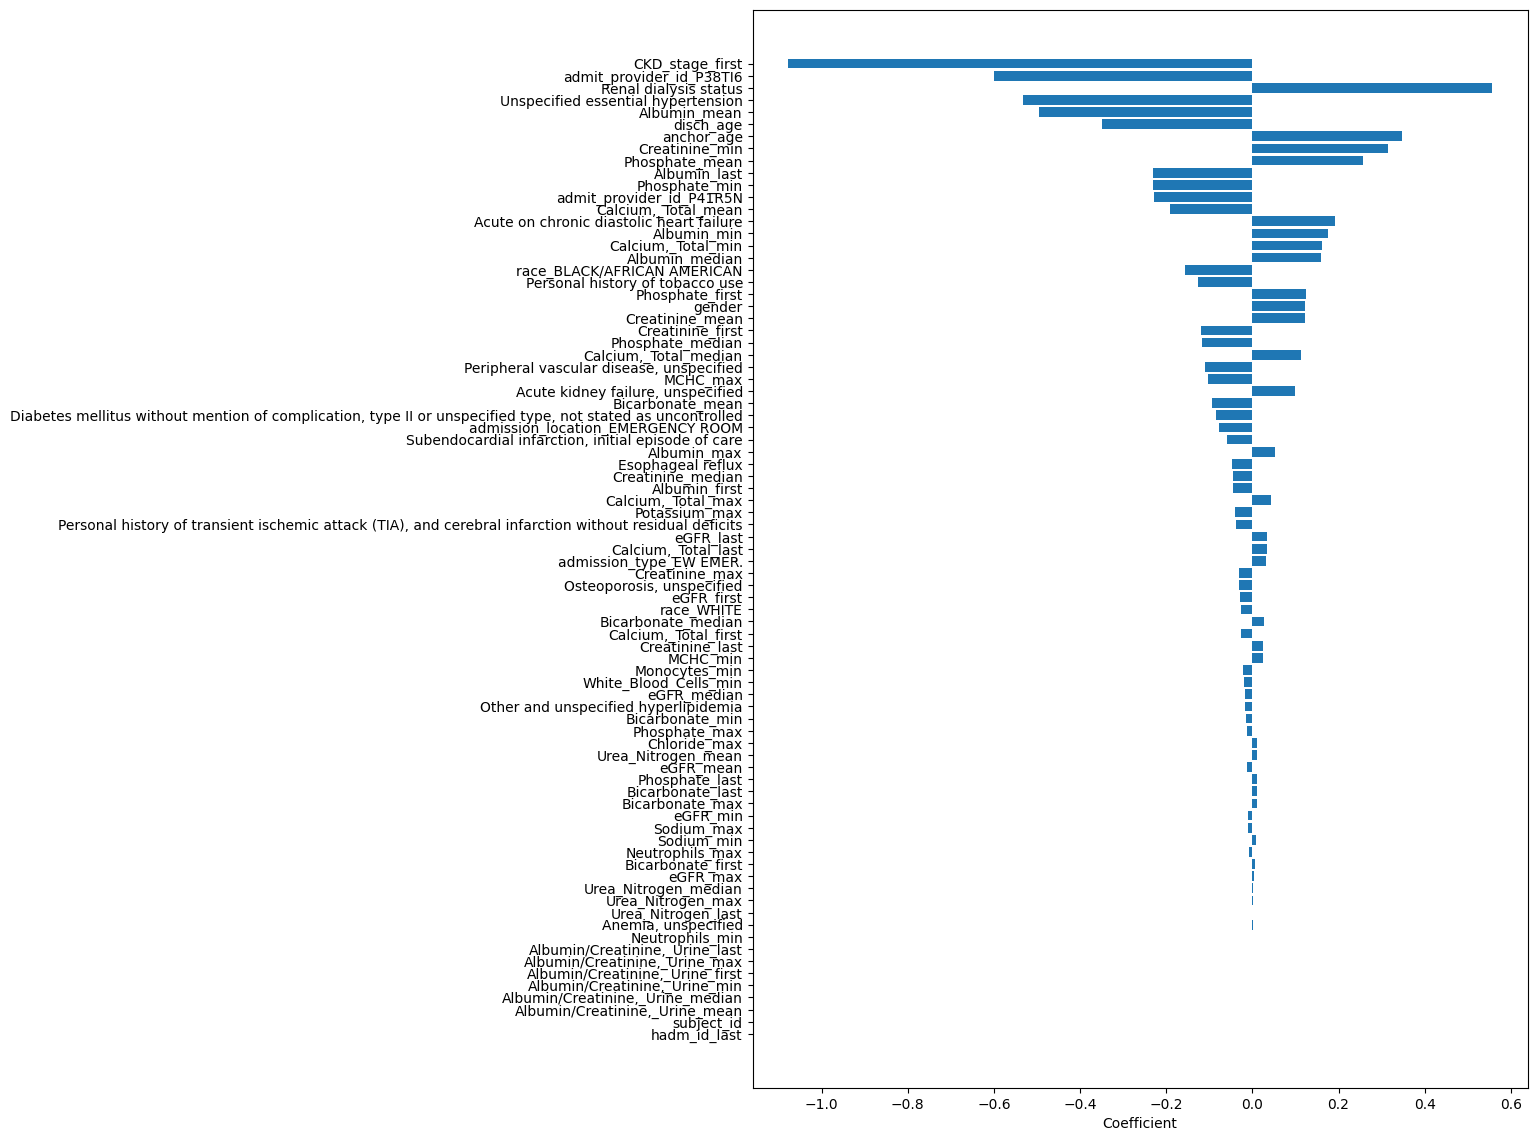

In [7]:
# Extract the coefficients and their corresponding feature names
coefficients = cph.params_
feature_importances = pd.DataFrame({
    'Feature': coefficients.index,
    'Coefficient': coefficients.values
})

# Sort the features by the absolute value of the coefficients
feature_importances['Abs_Coefficient'] = feature_importances['Coefficient'].abs()
feature_importances = feature_importances.sort_values(by='Abs_Coefficient', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 14))
plt.barh(feature_importances['Feature'], feature_importances['Coefficient'])
plt.xlabel('Coefficient')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top

# Save the plot as a PNG file
plt.savefig("figs/FCNNFeatures.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

# Schoenfeld Test

In [8]:
# Perform Schoenfeld test to assess the proportional hazards assumption
results = proportional_hazard_test(cph, train, time_transform='rank')
results_summary = results.summary

# Save the results summary to a CSV file
results_summary.to_csv('FCNNSchoenfeld.csv', index=True)

display(results_summary)

,test_statistic,p,-log2(p)
"Acute kidney failure, unspecified",2.261062,0.132663,2.914161
Acute on chronic diastolic heart failure,0.022022,0.882030,0.181101
"Albumin/Creatinine,_Urine_first",0.687240,0.407105,1.296528
"Albumin/Creatinine,_Urine_last",0.147588,0.700851,0.512821
"Albumin/Creatinine,_Urine_max",0.182597,0.669151,0.579597
...,...,...,...
gender,3.011423,0.082680,3.596324
hadm_id_last,0.139830,0.708450,0.497263
race_BLACK/AFRICAN AMERICAN,1.523787,0.217047,2.203919
race_WHITE,0.141961,0.706339,0.501566


# Brier Score Plot

In [9]:
# Prepare the survival data in the format required by scikit-survival
survival_train = Surv.from_dataframe('stage_delta', 'duration', train)
survival_test = Surv.from_dataframe('stage_delta', 'duration', test)

# Prepare the feature data
X_train = train.drop(columns=['duration', 'stage_delta'])
X_test = test.drop(columns=['duration', 'stage_delta'])

# Predict the survival function for the test data using the fitted model
survival_functions = cph.predict_survival_function(X_test)

# Extract available times directly from the survival functions
available_times = survival_functions.index

# Ensure valid_times are strictly within the follow-up time range of the test data
test_duration_min, test_duration_max = test['duration'].min(), test['duration'].max()
valid_times = available_times[(available_times > test_duration_min) & (available_times < test_duration_max)]

# Extract survival probabilities at the specified time points
estimate = survival_functions.loc[valid_times].T.values

# Calculate Brier scores using scikit-survival
valid_times, brier_scores = brier_score(
    survival_train=survival_train,
    survival_test=survival_test,
    estimate=estimate,
    times=valid_times
)

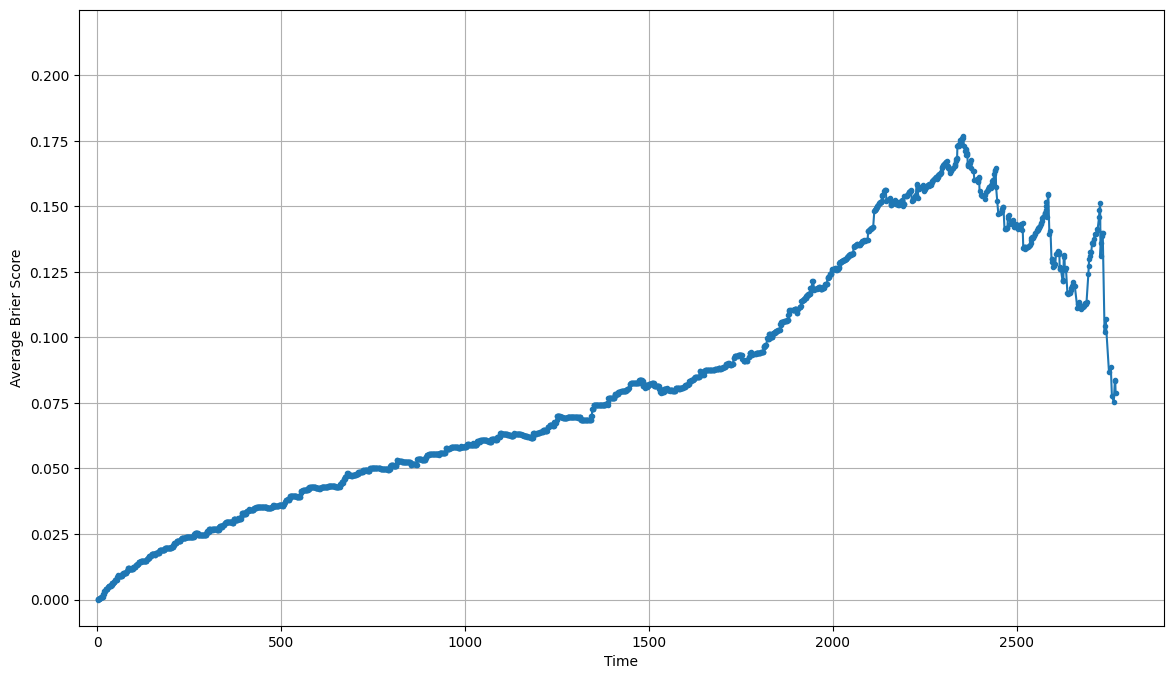

In [10]:
# Create a plot of Brier scores over time
plt.figure(figsize=(14, 8))
plt.plot(valid_times, brier_scores, marker='o', markersize=3)  # Adjust markersize here
plt.xlabel('Time')
plt.ylabel('Average Brier Score')
plt.yticks(np.arange(0, 0.225, 0.025))
plt.grid(True)
plt.xlim(-50, 2900)
plt.ylim(-0.01, 0.225)

# Save the plot as a PNG file
plt.savefig("figs/FCNNBrier.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

# Time-Dependent ROC Curves

In [11]:
# Predict risk scores for the test data using the fitted model
risk_scores = cph.predict_partial_hazard(X_test)

# Define time points to evaluate ROC curves
times = np.arange(1, test['duration'].max() + 1, 1)

# Ensure times are within the follow-up time range of the test data
valid_times = times[(times >= test['duration'].min()) & (times < test['duration'].max())]

# Compute time-dependent ROC curves using valid times
auc_values, mean_auc = cumulative_dynamic_auc(survival_train, survival_test, risk_scores, valid_times)

C:\Users\zdana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sksurv\metrics.py:482: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


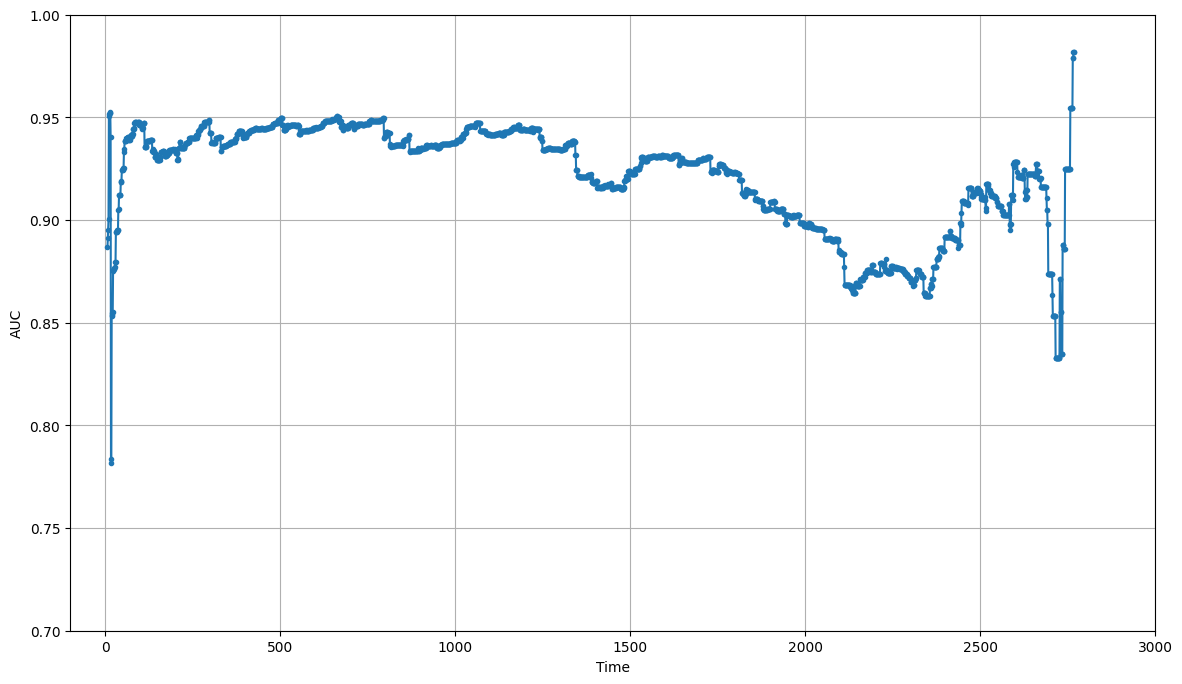

In [12]:
# Plot mean AUC over time
plt.figure(figsize=(14, 8))
plt.plot(valid_times, auc_values, marker='o', markersize=3)
plt.xlabel('Time')
plt.ylabel('AUC')
plt.grid(True)
plt.xlim(-100, 3000)
plt.ylim(0.70, 1.0)

# Save the plot as a PNG file
plt.savefig("figs/FCNNTimeDepAUC.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

# Visualize the Survival Functions by CKD Stage

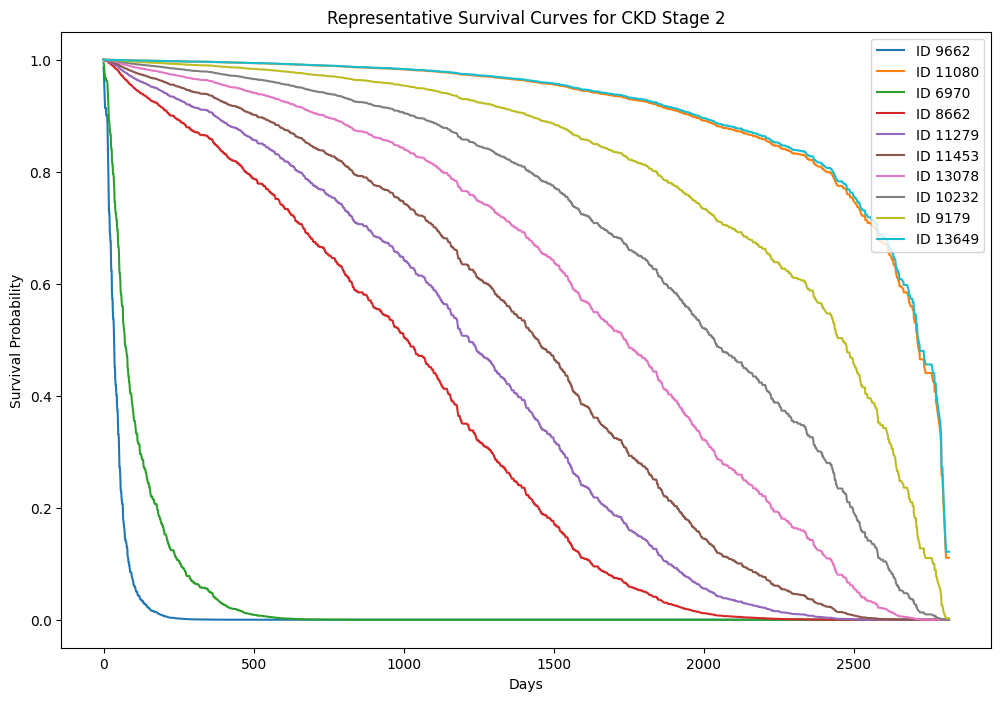

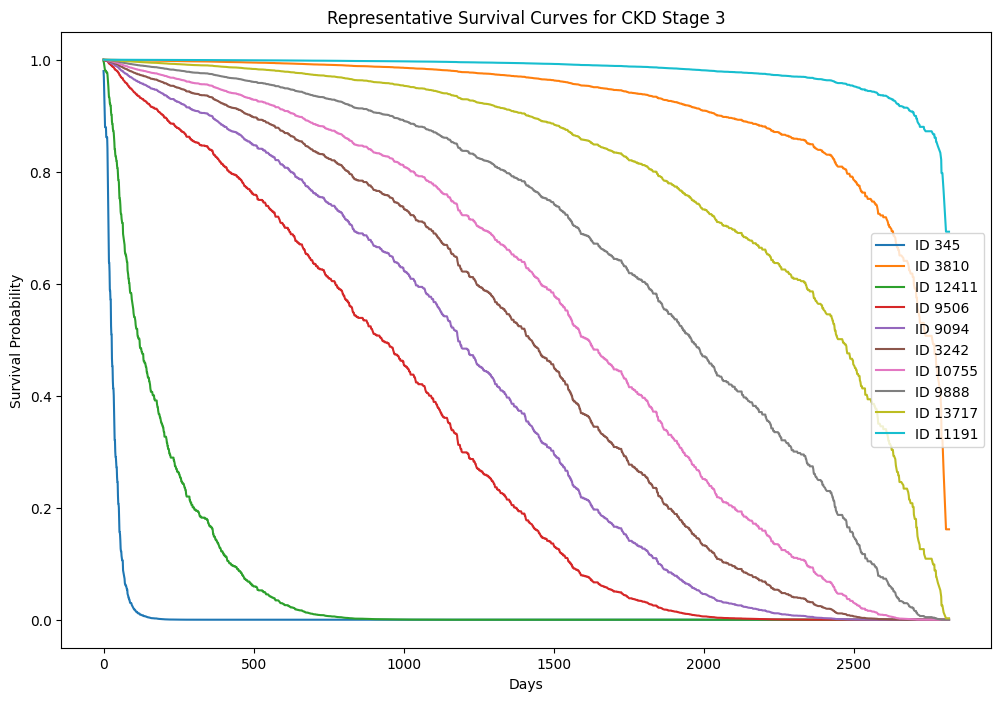

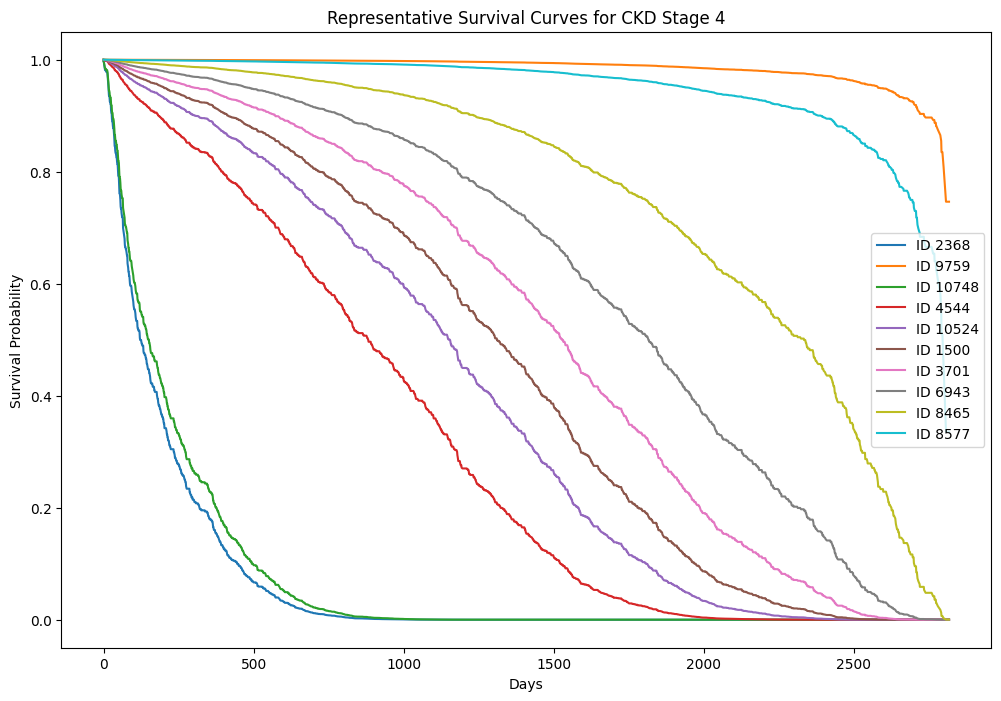

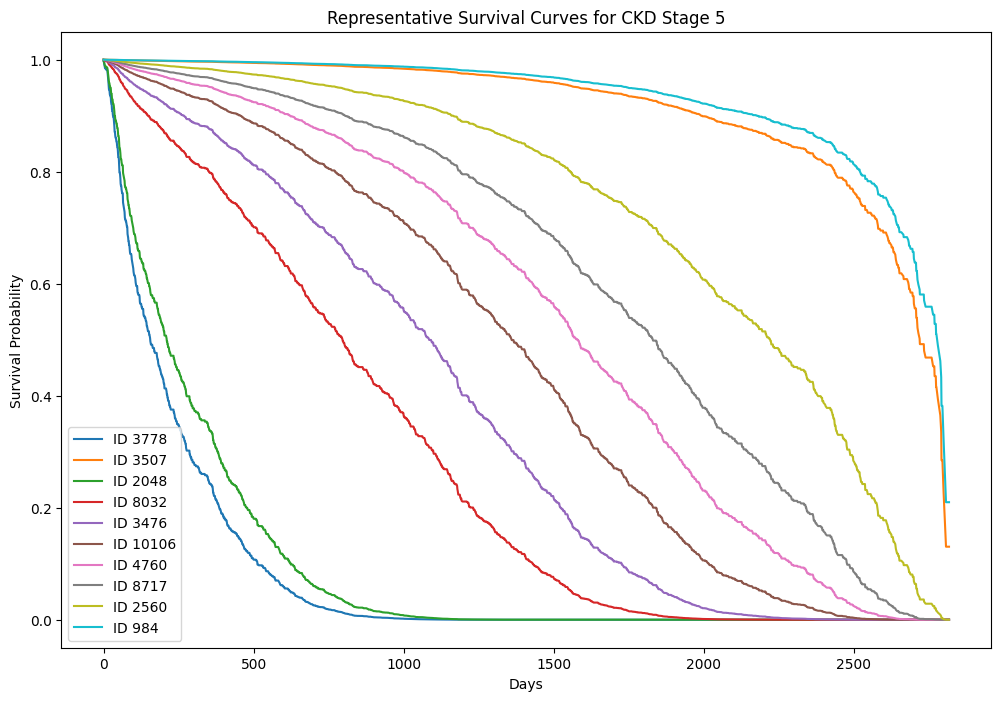

In [13]:
# Iterate through CKD stages 1 to 5 and plot the survival curves for each stage
for stage in range(2, 6):
    plot_survival_curves_for_stage(stage, 'FCNN', test, cph)